In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [103]:
#df_trd 불러오기
table_nm = 'DLAB_INTERN_TR_IFO_TMP' 
names = ['iqr_dt','cus_no','act_no','mkt_gb','pdt_gb','iem_cd','iem_krl_anm','bnc_qty','tot_aet_amt'] 

file_path = f'/home/sbx/data/DATA0113/DATA/{table_nm}.csv' 
df_trd = pd.read_csv(file_path,  names = names) 
df_trd.head()

FileNotFoundError: [Errno 2] File b'/home/sbx/data/DATA0113/DATA/DLAB_INTERN_TR_IFO_TMP.csv' does not exist: b'/home/sbx/data/DATA0113/DATA/DLAB_INTERN_TR_IFO_TMP.csv'

In [4]:
#df_cus 불러오기
table_nm = 'DLAB_HT_L1_CUS_IFO_TMP' 
names = ['cus_no','sex_dit_cd','cus_age','zip_ctp_cd', 'tco_cus_grd_cd', 'ivs_icn_cd'] 

file_path = f'/home/sbx/data/DATA0113/DATA/{table_nm}.csv' 
df_cus = pd.read_csv(file_path,  names = names) 
df_cus.head()

,cus_no,sex_dit_cd,cus_age,zip_ctp_cd,tco_cus_grd_cd,ivs_icn_cd
0,103139301,2,29,44,05,02
1,102997409,2,27,11,09,04
2,103481357,2,30,31,09,-
3,104565295,2,25,28,09,03
4,102932829,2,28,11,05,03


In [5]:
#df_act 불러오기
table_nm = 'DLAB_HT_L1_ACT_IFO_TMP' 
names = ['act_no','cus_no','act_opn_ym'] 

file_path = f'/home/sbx/data/DATA0113/DATA/{table_nm}.csv' 
df_act = pd.read_csv(file_path,  names = names) 
df_act.head()

,act_no,cus_no,act_opn_ym
0,20403262584,7367714,202102
1,20404262584,7367714,202102
2,20401262584,7367714,202102
3,9088211594,7367714,200511
4,20402262584,7367714,202102


In [6]:
# Making and cleaning data set to cluster
df_bal = df_trd.copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal = df_bal.reset_index()

df_bal_kor = df_trd[df_trd['mkt_gb'] == '국내'].copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal_kor = df_bal_kor.reset_index()

df_bal_ovs = df_trd[df_trd['mkt_gb'] == '해외'].copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal_ovs = df_bal_ovs.reset_index()

df_bal_tot = pd.merge(left=df_bal, 
                      right=df_bal_kor[['iqr_dt','cus_no', 'tot_aet_amt']], 
                      on=['cus_no', 'iqr_dt'], 
                      suffixes=('', '_kr'), 
                      how='left')
df_bal_tot = pd.merge(left=df_bal_tot, 
                      right=df_bal_ovs[['iqr_dt','cus_no', 'tot_aet_amt']], 
                      on=['cus_no', 'iqr_dt'], 
                      suffixes=('', '_ov'), 
                      how='left')

df_bal_tot[['tot_aet_amt_kr', 'tot_aet_amt_ov']] = df_bal_tot[['tot_aet_amt_kr', 'tot_aet_amt_ov']].fillna(0)

bank_cus = pd.merge(left=df_cus, right = df_bal_tot, on='cus_no', suffixes=('',''))
bank_cus['ovs_ratio'] = bank_cus['tot_aet_amt_ov']/bank_cus['tot_aet_amt']

In [7]:
df_bal_list = []
df_bal_len = []
df_cus_w = df_cus.copy()[(df_cus['cus_no'].isin(df_trd['cus_no'])) & ~(df_cus['cus_no'].isin(df_trd[(df_trd['iem_cd'] == "US25459W4583")]['cus_no']))]
for i in df_bal_tot['iqr_dt'].unique():
    df = df_bal_tot[df_bal_tot['iqr_dt'] == i]
    df = pd.merge(left=df_cus_w, right=df, on='cus_no', suffixes=('','')) #if how='left', customers who haven't opened an account appear
    df['ovs_ratio'] = df['tot_aet_amt_ov'] / df['tot_aet_amt']
    df_bal_list.append(df)
    df_bal_len.append(len(df))

In [8]:
df_bal_list_10_19 = []
df_bal_list_20_24 = []
df_bal_list_25_30 = []
for i in range(len(df_bal_list)):
    df_bal_list_10_19.append(df_bal_list[i][(df_bal_list[i]['cus_age'] > 9) & (df_bal_list[i]['cus_age'] < 20)])
    df_bal_list_20_24.append(df_bal_list[i][(df_bal_list[i]['cus_age'] > 19) & (df_bal_list[i]['cus_age'] < 25)])
    df_bal_list_25_30.append(df_bal_list[i][(df_bal_list[i]['cus_age'] > 24) & (df_bal_list[i]['cus_age'] < 31)])

In [9]:
#20대 초반 투자자 해외투자 비중 변화
#20대 초반 투자자 해외투자액 변화

df_list = df_bal_list_20_24
num_ppl = []
ovs_pct = []
ovs_pct_ratio = []
ovs_avg_ratio = []
ovs_tot_amt = []
for i in range(182):
    df = df_list[i]
    df_hlf = df[df['ovs_ratio'] > 0.5]
    df_ovs = df[df['ovs_ratio'] > 0]
    ovs_pct.append(len(df[df['ovs_ratio'] > 0])/len(df))
    ovs_pct_ratio.append(len(df_hlf)/len(df_ovs))
    ovs_avg_ratio.append(df_ovs['ovs_ratio'].mean())
    ovs_tot_amt.append(df['tot_aet_amt_ov'].sum())
# pd.DataFrame(ovs_pct).plot()
# pd.DataFrame(ovs_tot_amt).plot()
# len(df_list[1])

In [10]:
# Combining the dataset into one dataframe
df_bank_cus = pd.concat([df_bal_list_10_19[181],df_bal_list_20_24[181],df_bal_list_25_30[181]], axis=0)
df_bank_cus

,cus_no,sex_dit_cd,cus_age,zip_ctp_cd,tco_cus_grd_cd,ivs_icn_cd,iqr_dt,tot_aet_amt,tot_aet_amt_kr,tot_aet_amt_ov,ovs_ratio
8,102288011,1,13,44,05,-,20210701,4862500,4862500.0,0.0,0.000000
19,102655907,1,17,11,05,03,20210701,17364000,17364000.0,0.0,0.000000
22,104534086,1,16,30,05,02,20210701,7483126,80100.0,7403026.0,0.989296
36,103190797,2,13,44,09,05,20210701,568200,568200.0,0.0,0.000000
37,102913522,1,15,41,05,-,20210701,27527500,27527500.0,0.0,0.000000
49,103738482,1,14,43,09,-,20210701,191800,191800.0,0.0,0.000000
52,104558111,2,10,28,09,03,20210701,1280800,1280800.0,0.0,0.000000
53,103063810,1,10,41,05,04,20210701,22386900,22386900.0,0.0,0.000000
58,103283554,2,17,41,05,02,20210701,10893600,10893600.0,0.0,0.000000
59,102763782,2,16,41,05,-,20210701,14596500,14596500.0,0.0,0.000000


In [101]:
df_trd[['bnc_qty','cus_no','iqr_dt','iem_krl_anm']].groupby(['cus_no','iqr_dt','iem_krl_anm']).count()
print()

In [12]:
# df_trd 테이블 조회 및 그룹
df_trd_copy = df_trd.copy()
# df_trd_copy['bnc_qty'].astype(int)
df_test = df_trd_copy[df_trd_copy['bnc_qty'] !=  ' Inc.']
bnc_int = df_test['bnc_qty'].astype(int)

df_test['bnc_qty'] = bnc_int
counting = df_test[['bnc_qty','cus_no','iqr_dt','iem_krl_anm']].groupby(['cus_no','iqr_dt','iem_krl_anm']).sum()

df_trd.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,iqr_dt,cus_no,act_no,mkt_gb,pdt_gb,iem_cd,iem_krl_anm,bnc_qty,tot_aet_amt
0,20210510,7367714,20401262584,국내,주식,A027360,아주IB투자,25,177000
1,20210519,7367714,20401262584,국내,주식,A027360,아주IB투자,25,173250
2,20210522,7367714,20401262584,국내,주식,A027360,아주IB투자,25,177000
3,20210518,7367714,20401262584,국내,주식,A027360,아주IB투자,25,173250
4,20210609,7367714,20401262584,국내,주식,A027360,아주IB투자,25,197500


In [13]:
# cus_no 별 bnc_qty 조회
countings = df_test[['bnc_qty','cus_no','iqr_dt']].groupby(['cus_no','iqr_dt']).sum()

getting_index = df_test[['cus_no','iqr_dt']].groupby(['cus_no']).count()
index_countings = getting_index.index
# countings

bnc_qty
cus_no    iqr_dt           
7367714   20210303       60
          20210304       60
          20210305       73
          20210306       73
          20210307       73
          20210308       73
          20210309       93
          20210310      193
          20210311      187
          20210312      189
          20210313      189
          20210314      189
          20210315      189
          20210316      189
          20210317      189
          20210318      189
          20210319      191
          20210320      191
          20210321      191
          20210322      191
          20210323       85
          20210324       85
          20210325      262
          20210326      262
          20210327      262
          20210328      262
          20210329      303
          20210330      303
          20210331      303
          20210401      303
...                     ...
104677733 20210621        1
          20210622        1
          20210623        1
          20210624        1
          20210625        3
          20210626        3
          20210627        3
          20210628        3
          20210629        4
          20210630        4
          20210701        4
104677981 20210621        6
          20210622        6
          20210623        6
          20210624        6
          20210625        7
          20210626        7
          20210627        7
          20210628        7
          20210629        7
          20210630        7
          20210701        8
104686253 20210628        4
          20210629       24
          20210630      147
          20210701      147
104695889 20210628        2
          20210629        9
          20210630        9
          20210701       10

[60539 rows x 1 columns]

In [14]:
# 매매빈도를 위한 helper function 
# bnc_qty의 값이 다르면 counter 세기
def counter(a,b):
    count = 0
    for i in range(a,b,1):
        if i < (b-a)-1:
            if countings['bnc_qty'][i] != countings['bnc_qty'][i+1]:
                count += 1
    return count

lst = [0]
for i in range(getting_index.shape[0]):
    lst.append(getting_index['iqr_dt'].iloc[i])

In [18]:
# Helper function 인 counter를 이용한 매매빈도 list 추출 << 좀 오래 걸림
res = []
for i in range(len(lst)):
    if i < len(lst)-1:
        n = lst[i] + lst[i+1]
        val = counter(lst[i], n)
    res.append(val)
    
res

print()

In [100]:
# 주식 매매빈도를 구하기 위한 정리
df_trd.head()
testing = df_trd.copy()
vals = []
for i in range(testing.shape[0]):
    vals.append(1)

testing['ones'] = vals

countings = df_test[['bnc_qty','cus_no','iqr_dt']].groupby(['cus_no','iqr_dt']).sum()

getting_index = df_test[['cus_no','iqr_dt']].groupby(['cus_no']).count()
index_countings = getting_index.index

testings = testing[['ones','cus_no','iqr_dt']].groupby(['cus_no','iqr_dt']).count()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7835e5aac8>]],
      dtype=object)

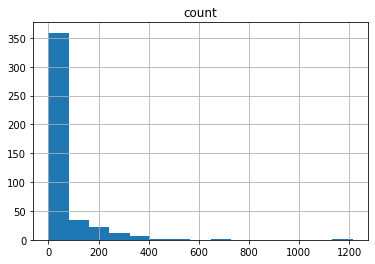

In [20]:
# 주식 매매빈도 그래프
getting_index['count'] = res[:440]
getting_index

counting_trade_num = getting_index.drop(columns = 'iqr_dt')
counting_trade_num.hist(bins=15)

In [25]:
# Making and cleaning data set to cluster
df_bal = df_trd.copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal = df_bal.reset_index()

df_bal_kor_stk = df_trd[(df_trd['mkt_gb'] == '국내') & (df_trd['pdt_gb'] == '주식')].copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal_kor_stk = df_bal_kor_stk.reset_index()
df_bal_ovs_stk = df_trd[(df_trd['mkt_gb'] == '해외') & (df_trd['pdt_gb'] == '주식')].copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal_ovs_stk = df_bal_ovs_stk.reset_index()

df_bal_kor_etf = df_trd[(df_trd['mkt_gb'] == '국내') & (df_trd['pdt_gb'] == 'ETF')].copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal_kor_etf = df_bal_kor_etf.reset_index()
df_bal_ovs_etf = df_trd[(df_trd['mkt_gb'] == '해외') & (df_trd['pdt_gb'] == 'ETF')].copy()[['iqr_dt', 'cus_no', 'tot_aet_amt']].groupby(['iqr_dt', 'cus_no']).sum()
df_bal_ovs_etf = df_bal_ovs_etf.reset_index()


df_bal_tot = pd.merge(left=df_bal, 
                      right=df_bal_kor_stk[['iqr_dt','cus_no', 'tot_aet_amt']], 
                      on=['cus_no', 'iqr_dt'], 
                      suffixes=('', '_kor_stk'), 
                      how='left')
df_bal_tot = pd.merge(left=df_bal_tot, 
                      right=df_bal_ovs_stk[['iqr_dt','cus_no', 'tot_aet_amt']], 
                      on=['cus_no', 'iqr_dt'], 
                      suffixes=('', '_ovs_stk'), 
                      how='left')
df_bal_tot = pd.merge(left=df_bal_tot, 
                      right=df_bal_kor_etf[['iqr_dt','cus_no', 'tot_aet_amt']], 
                      on=['cus_no', 'iqr_dt'], 
                      suffixes=('', '_kor_etf'), 
                      how='left')
df_bal_tot = pd.merge(left=df_bal_tot, 
                      right=df_bal_ovs_etf[['iqr_dt','cus_no', 'tot_aet_amt']], 
                      on=['cus_no', 'iqr_dt'], 
                      suffixes=('', '_ovs_etf'), 
                      how='left')

df_bal_tot[['tot_aet_amt_kor_stk', 'tot_aet_amt_ovs_stk', 'tot_aet_amt_kor_etf', 'tot_aet_amt_ovs_etf']] = df_bal_tot[['tot_aet_amt_kor_stk', 'tot_aet_amt_ovs_stk', 'tot_aet_amt_kor_etf', 'tot_aet_amt_ovs_etf']].fillna(0)

df_bal_list = []
df_bal_len = []
for i in df_bal_tot['iqr_dt'].unique():
    df = df_bal_tot[df_bal_tot['iqr_dt'] == i]
    df = pd.merge(left=df_cus_w, right=df, on='cus_no', suffixes=('','')) #if how='left', customers who haven't opened an account appear
    df['kor_etf_ratio'] = df['tot_aet_amt_kor_etf'] / (df['tot_aet_amt_kor_stk']+df['tot_aet_amt_kor_etf'])
    df['ovs_etf_ratio'] = df['tot_aet_amt_ovs_etf'] / (df['tot_aet_amt_ovs_stk']+df['tot_aet_amt_ovs_etf'])
    df[['kor_etf_ratio', 'ovs_etf_ratio']] = df[['kor_etf_ratio', 'ovs_etf_ratio']].fillna(0)
    df_bal_list.append(df)
    df_bal_len.append(len(df))
    
df_getting = df_bal_list[181]
df_getting['cus_no']

(412, 14)

In [86]:
# Adding Count column to the modified data
counting_trade = counting_trade_num.reset_index()
count = counting_trade[counting_trade['cus_no'].isin(df_getting['cus_no'])]
count = count.set_index('cus_no')
count_lst = []
for i in count['count']:
    count_lst.append(i)
len(count_lst)


412

In [50]:
# Final df_bank_cus data set to cluster 
ten_thirty = df_bal_list[181].set_index(keys='cus_no')
df_bank_cus_copy = ten_thirty.drop(['ivs_icn_cd', 'iqr_dt', 'zip_ctp_cd'], axis=1)
df_bank_cus_copy = df_bank_cus_copy.reset_index().sort_values(by='cus_no')
df_bank_cus_copy['count'] = count_lst
df_bank_cus_copy = df_bank_cus_copy.set_index('cus_no')
df_bank_cus_copy.head()

,sex_dit_cd,cus_age,tco_cus_grd_cd,tot_aet_amt,tot_aet_amt_kor_stk,tot_aet_amt_ovs_stk,tot_aet_amt_kor_etf,tot_aet_amt_ovs_etf,kor_etf_ratio,ovs_etf_ratio,count
cus_no,,,,,,,,,,,
7367714,2,28,09,3778660,3778660.0,0.0,0.0,0.0,0.000000,0.000000,195
7370887,1,27,05,22515901,7710150.0,5896216.0,8909535.0,0.0,0.536083,0.000000,271
7371137,1,27,09,317000,317000.0,0.0,0.0,0.0,0.000000,0.000000,0
100387822,2,11,09,3525011,807400.0,1833788.0,0.0,883823.0,0.000000,0.325221,163
100493434,2,22,03,38514256,24644760.0,13869496.0,0.0,0.0,0.000000,0.000000,274


In [79]:
df_cus.head()

,cus_no,sex_dit_cd,cus_age,zip_ctp_cd,tco_cus_grd_cd,ivs_icn_cd
0,103139301,2,29,44,05,02
1,102997409,2,27,11,09,04
2,103481357,2,30,31,09,-
3,104565295,2,25,28,09,03
4,102932829,2,28,11,05,03


In [51]:
from kmodes.kmodes import KModes

In [52]:
# Choosing K 
cost = []
for clusters in list(range(1,10)):
    modes = KModes(n_clusters=clusters, init = "Random", n_init=5, verbose=1)
    modes.fit_predict(df_bank_cus_copy)
    cost.append(modes.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1892.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 1892.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 1892.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 1892.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 1892.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 27, cost: 1776.0
Run 1, iteration: 2/100, moves: 51, cost: 1775.0
Run 1, iteration: 3/100, moves: 0, cost: 1775.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 

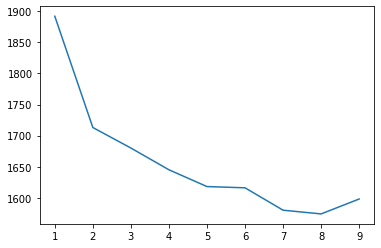

In [54]:
graph = np.array([i for i in range (1,10,1)])
plt.plot(graph, cost)

In [55]:
# KModes clustering ran 10 times with K=8
km = KModes(n_clusters=8, init="Random", n_init=10, verbose=1)
fit_clusters = km.fit_predict(df_bank_cus_copy)


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 95, cost: 1616.0
Run 1, iteration: 2/100, moves: 3, cost: 1616.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 79, cost: 1584.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 232, cost: 1587.0
Run 3, iteration: 2/100, moves: 10, cost: 1586.0
Run 3, iteration: 3/100, moves: 0, cost: 1586.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 151, cost: 1572.0
Run 4, iteration: 2/100, moves: 17, cost: 1572.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 261, cost: 1567.0
Run 5, iteration: 2/100, moves: 4, cost: 1564.0
Run 5, iteration: 3/100, moves: 2, cost: 1564.0
Init: initializing centroids
Init: initializing clusters
Start

In [56]:
# Input the predicted group into original data
df_bank_cus_copy['cluster'] = fit_clusters
df_bank_cus_copy.head()

,sex_dit_cd,cus_age,tco_cus_grd_cd,tot_aet_amt,tot_aet_amt_kor_stk,tot_aet_amt_ovs_stk,tot_aet_amt_kor_etf,tot_aet_amt_ovs_etf,kor_etf_ratio,ovs_etf_ratio,count,cluster
cus_no,,,,,,,,,,,,
7367714,2,28,09,3778660,3778660.0,0.0,0.0,0.0,0.000000,0.000000,195,1
7370887,1,27,05,22515901,7710150.0,5896216.0,8909535.0,0.0,0.536083,0.000000,271,0
7371137,1,27,09,317000,317000.0,0.0,0.0,0.0,0.000000,0.000000,0,3
100387822,2,11,09,3525011,807400.0,1833788.0,0.0,883823.0,0.000000,0.325221,163,1
100493434,2,22,03,38514256,24644760.0,13869496.0,0.0,0.0,0.000000,0.000000,274,4


In [98]:
#cluster_0 top 5
cluster_0 = df_bank_cus_copy[df_bank_cus_copy['cluster'] == 0].reset_index()
table_0 = df_trd[(df_trd['iqr_dt'] == 20210701) & (df_trd['cus_no'].isin(cluster_0['cus_no']))].groupby('iem_krl_anm').count().sort_values(by='iqr_dt', ascending=False).head()
table_0 = table_0.drop(columns =['iqr_dt', 'cus_no', 'act_no','mkt_gb','pdt_gb','iem_cd','tot_aet_amt'])
table_0

,bnc_qty
iem_krl_anm,
삼성전자,30
애플,10
삼성전자우,10
현대차,7
삼성전기,6


In [99]:
#cluster_1 top 5
cluster_1 = df_bank_cus_copy[df_bank_cus_copy['cluster'] == 1].reset_index()
table_1 = df_trd[(df_trd['iqr_dt'] == 20210701) & (df_trd['cus_no'].isin(cluster_1['cus_no']))].groupby('iem_krl_anm').count().sort_values(by='iqr_dt', ascending=False).head()
table_1 = table_1.drop(columns =['iqr_dt', 'cus_no', 'act_no','mkt_gb','pdt_gb','iem_cd','tot_aet_amt'])
table_1

,bnc_qty
iem_krl_anm,
삼성전자,91
카카오,34
삼성전자우,31
대한항공,20
HMM,13


In [59]:
#cluster_2 top 5
cluster_2 = df_bank_cus_copy[df_bank_cus_copy['cluster'] ==2].reset_index()
df_trd[(df_trd['iqr_dt'] == 20210701) & (df_trd['cus_no'].isin(cluster_2['cus_no']))].groupby('iem_krl_anm').count().sort_values(by='iqr_dt', ascending=False).head()

,iqr_dt,cus_no,act_no,mkt_gb,pdt_gb,iem_cd,bnc_qty,tot_aet_amt
iem_krl_anm,,,,,,,,
삼성전자,3,3,3,3,3,3,3,3
삼성전자우,2,2,2,2,2,2,2,2
TIGER 200,2,2,2,2,2,2,2,2
CJ CGV,1,1,1,1,1,1,1,1
Stem,1,1,1,1,1,1,1,1


In [60]:
#cluster_3 top 5
cluster_3 = df_bank_cus_copy[df_bank_cus_copy['cluster'] == 3].reset_index()
df_trd[(df_trd['iqr_dt'] == 20210701) & (df_trd['cus_no'].isin(cluster_3['cus_no']))].groupby('iem_krl_anm').count().sort_values(by='iqr_dt', ascending=False).head()

,iqr_dt,cus_no,act_no,mkt_gb,pdt_gb,iem_cd,bnc_qty,tot_aet_amt
iem_krl_anm,,,,,,,,
삼성전자,41,41,41,41,41,41,41,41
대한항공,10,10,10,10,10,10,10,10
카카오,10,10,10,10,10,10,10,10
삼성전자우,7,7,7,7,7,7,7,7
현대차,6,6,6,6,6,6,6,6


In [61]:
# cluster_4 top 5 
cluster_4 = df_bank_cus_copy[df_bank_cus_copy['cluster'] == 4].reset_index()
df_trd[(df_trd['iqr_dt'] == 20210701) & (df_trd['cus_no'].isin(cluster_4['cus_no']))].groupby('iem_krl_anm').count().sort_values(by='iqr_dt', ascending=False).head()

,iqr_dt,cus_no,act_no,mkt_gb,pdt_gb,iem_cd,bnc_qty,tot_aet_amt
iem_krl_anm,,,,,,,,
삼성전자,15,15,15,15,15,15,15,15
삼성전자우,7,7,7,7,7,7,7,7
카카오,4,4,4,4,4,4,4,4
대한항공,3,3,3,3,3,3,3,3
박셀바이오,2,2,2,2,2,2,2,2


In [67]:
# Naming cluster 5,6,7
cluster_5 = df_bank_cus_copy[df_bank_cus_copy['cluster'] == 5].reset_index()
cluster_6 = df_bank_cus_copy[df_bank_cus_copy['cluster'] == 6].reset_index()
cluster_7 = df_bank_cus_copy[df_bank_cus_copy['cluster'] == 7].reset_index()

In [93]:
#Getting the mean val of all the columns to check each group's features
df_used = df_bank_cus_copy.groupby('cluster').mean()
df_ovs = (df_used['tot_aet_amt_ovs_etf'] + df_used['tot_aet_amt_ovs_stk'])/df_used['tot_aet_amt']
df_used['ovs_ratio'] = df_ovs
temp = df_used['count']
df_used = df_used.drop(columns=['count'])
df_used['count'] = temp
df_used

,sex_dit_cd,cus_age,tot_aet_amt,tot_aet_amt_kor_stk,tot_aet_amt_ovs_stk,tot_aet_amt_kor_etf,tot_aet_amt_ovs_etf,kor_etf_ratio,ovs_etf_ratio,ovs_ratio,count
cluster,,,,,,,,,,,
0,1.112676,26.507042,2.856821e+07,2.298315e+07,4.546243e+06,5.521689e+05,4.866565e+05,0.024023,0.051823,0.176171,92.802817
1,1.929825,25.251462,3.870537e+06,3.410064e+06,2.939557e+05,1.359560e+05,3.056149e+04,0.035892,0.014306,0.083843,40.836257
2,1.200000,24.400000,1.319322e+06,6.784500e+05,3.874140e+05,2.534580e+05,0.000000e+00,0.394098,0.000000,0.293646,72.600000
3,1.000000,22.168421,2.690021e+06,2.325960e+06,2.558960e+05,7.060626e+04,3.755885e+04,0.016406,0.013514,0.109090,21.600000
4,1.920000,22.320000,3.137272e+06,2.564970e+06,5.627211e+05,9.580200e+03,0.000000e+00,0.019571,0.000000,0.179366,30.000000
5,1.000000,28.555556,3.868440e+07,2.958310e+07,5.038776e+06,1.430977e+06,2.631549e+06,0.111111,0.084424,0.198280,147.333333
6,2.000000,25.000000,4.208169e+06,3.374189e+06,3.790983e+05,4.277444e+05,2.713762e+04,0.043870,0.010398,0.096535,83.687500
7,2.000000,23.950000,1.792431e+07,1.603650e+07,1.580579e+06,6.102775e+04,2.462050e+05,0.018584,0.049351,0.101917,102.250000


In [74]:
#Features of each group
cluster_0.shape #71  남성위주, 평균나이 26.5, 돈 평균이상, 해외거래 18프로, 거래횟수 많은편
cluster_1.shape #171  여성위주, 평균나이 25.25, 돈 평균이하, 해외거래 적음(8프로), 거래횟수 적은편
cluster_2.shape #5
cluster_3.shape #95
cluster_4.shape #25
cluster_5.shape #9
cluster_6.shape #16
cluster_7.shape #20

(20, 13)